config_cpp.lambdae=6.4878620732485315, config_cpp.ntokens=14
speedup_cpp=13.240534843364351
confFinal_cpp=['001', 'C']
config_sycl.lambdae=9.013754393741614, config_sycl.ntokens=8
speedup_sycl=18.395417130084926
confFinal_sycl=['001', 'C']
config_avx.lambdae=18.904615384615386, config_avx.ntokens=14
speedup_avx=38.58084772370487
confFinal_avx=['100', 'E']
config_simd.lambdae=19.622690830348187, config_simd.ntokens=13
speedup_simd=40.04630781703712
confFinal_simd=['010', 'G']


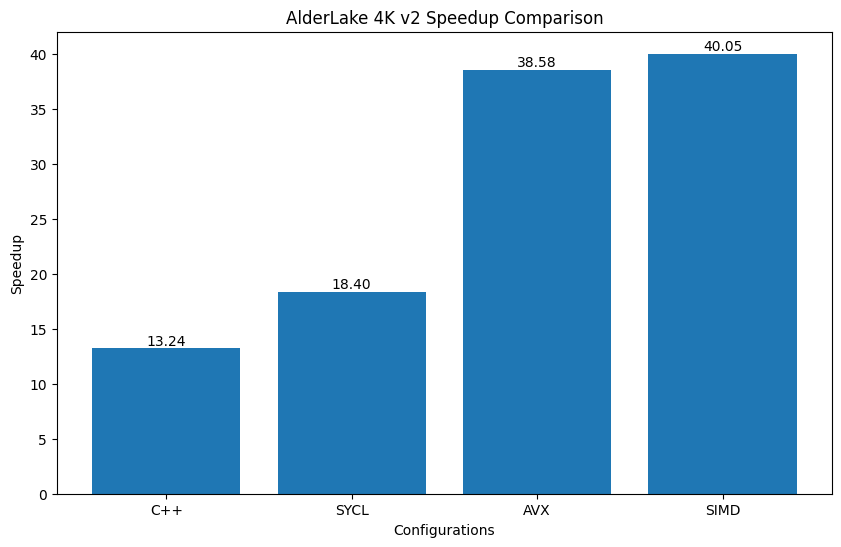

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Stage:
    def __init__(self, llegada, activo, nstream, nterm):
        self.llegada = llegada
        self.activo = activo
        self.nstream = nstream
        self.nterm = nterm
        self.Lq = 0
        self.Wq = 0
        self.tasa = 0
        self.prob_ocupado = 0
        self.ro = 0

    def calcular_metricas(self):
        z = self.activo / self.llegada
        f = []
        fp = []
        pn = []
        p1 = []

        for i in range(self.nterm):
            if i <= self.nstream - 1:
                f.append((self.nterm - i) * self.activo / (self.llegada * (i + 1)))
            else:
                f.append((self.nterm - i) * self.activo / (self.llegada * self.nstream))

        for i in range(1, self.nterm + 1):
            vect = np.prod(f[:i])
            fp.append(vect)

        p0 = 1 / (1 + sum(fp))

        for i in range(1, self.nterm + 1):
            vect = np.prod(f[:i])
            pn.append(vect * p0)

        prob_ocupado = sum(pn[self.nstream - 1:])

        for i in range(self.nterm):
            p1.append((i + 1) * pn[i])

        L = sum(p1)
        self.Lq = max(0, L - (z * (self.nterm - L)))
        self.Wq = (self.Lq * self.llegada) / (self.nterm - L)
        self.tasa = (self.nterm - L) / self.llegada
        self.ro = self.tasa * self.activo / self.nstream
        self.prob_ocupado = prob_ocupado

class SystemConfiguration:
    def __init__(self, nstages, thC, thG, nc):
        self.nstages = nstages
        self.thC = thC
        self.thG = thG
        self.nc = nc
        self.lambdaOpt = 0
        self.confOptP = []
        self.confOptS = 0
        self.lambdae = 0
        self.ntokens = 0

    def find_optimal_configuration(self):
        confP = ['0'] * self.nstages
        botlC, stC = min((val, idx) for (idx, val) in enumerate(self.thC))
        botlG, stG = min((val, idx) for (idx, val) in enumerate(self.thG))

        if botlC < botlG:
            confP[stC] = '1'
            stageBotl = stC
        else:
            confP[stG] = '0'
            stageBotl = stG

        TserCP = np.zeros(2**self.nstages - 1)
        TserGP = np.zeros(2**self.nstages - 1)
        TserCS = np.zeros(2**self.nstages - 1)
        TserGS = np.zeros(2**self.nstages - 1)

        p = np.ones(2**self.nstages - 1)
        Sdev = -np.ones(2**self.nstages - 1)
        rhoG = np.ones(2**self.nstages - 1)
        rhoC = np.ones(2**self.nstages - 1)
        lambda_vals = np.zeros(2**self.nstages - 1)

        for i in range(2**self.nstages - 1):
            if i == 2**self.nstages - 1:
                for k in range(self.nstages):
                    TserGP[i] += 1 / self.thG[k]
                    TserCP[i] += 1 / (self.thC[k] / self.nc)
                lambda_vals[i] = 1 / TserGP[i] + (1 / TserCP[i]) * self.nc
            else:
                conf = bin(i)[2:].zfill(self.nstages)
                if conf[stageBotl] == confP[stageBotl]:
                    for k in range(self.nstages):
                        if conf[k] == '1':
                            TserGP[i] += 1 / self.thG[k]
                            TserCS[i] += 1 / (self.thC[k] / self.nc)
                        else:
                            TserCP[i] += 1 / (self.thC[k] / self.nc)
                            TserGS[i] += 1 / self.thG[k]
                    if TserGP[i] == 0 or TserCP[i] == 0:
                        lambda_vals[i] = 0
                        continue

                    lambdaGP = 1 / TserGP[i]
                    lambdaCP = (1 / TserCP[i]) * self.nc
                    lambdaG = lambdaGP
                    lambdaC = lambdaCP

                    if lambdaGP < 0.9 * lambdaCP:
                        rhoC[i] = ((self.nc * TserGP[i] + TserCS[i]) / (TserGP[i] * TserCS[i])) * ((TserCP[i] * TserCS[i]) / (TserCP[i] + TserCS[i])) * (1 / self.nc)
                        cP = max(round(self.nc * rhoC[i]), 1)
                        cS = self.nc - cP
                        if rhoC[i] < 0.8:
                            Sdev[i] = 0
                            lambdaG = lambdaGP + ((1 / TserCS[i]) * self.nc) * (1 - rhoC[i])
                            lambdaC = lambdaCP * rhoC[i]
                            p[i] = lambdaGP / lambdaG
                    else:
                        if lambdaCP < 0.9 * lambdaGP:
                            rhoG[i] = ((self.nc * TserGS[i] + TserCP[i]) / (TserGS[i] * TserCP[i])) * ((TserGP[i] * TserGS[i]) / (TserGP[i] + TserGS[i]))
                            if rhoG[i] < 0.8:
                                Sdev[i] = 1
                                lambdaG = lambdaGP * rhoG[i]
                                lambdaC = lambdaCP + (1 / TserGS[i]) * (1 - rhoG[i])
                                p[i] = lambdaCP / lambdaC

                    lambda_vals[i] = min(lambdaG, lambdaC)
                else:
                    lambda_vals[i] = 0

        self.lambdaOpt = max(lambda_vals)
        id_opt = np.argmax(lambda_vals)
        self.confOptP = bin(id_opt)[2:].zfill(self.nstages)
        self.confOptS = Sdev[id_opt]

        romax = 0.95
        if id_opt == 2**self.nstages - 1:
            Tarrive = TserGP[id_opt]
        else:
            if self.confOptS == 0:
                Tarrive = 1 / (p[id_opt] * self.lambdaOpt)
            elif self.confOptS == 1:
                Tarrive = 1 / self.lambdaOpt
                romax = 0.95 * rhoG[id_opt]
            else:
                Tarrive = 1 / self.lambdaOpt

        # Definir valores de lambdae para las etapas
        lambdaeGP = 0
        lambdaeCP = 0
        lambdaeCS = 0
        lambdaeGS = 0

        # Calcular para la GPU primaria
        TserG = TserGP[id_opt]
        c = 1
        NGP = 0
        roG = 0
        while roG < romax:
            NGP += 1
            stage = Stage(Tarrive, TserG, c, NGP)
            stage.calcular_metricas()
            roG = stage.ro
            lambdaeGP = stage.tasa
        
        # Calcular para la CPU primaria
        romax = 0.95
        if id_opt == 2**self.nstages - 1:
            Tarrive = TserCP[id_opt]
            cP = self.nc
        else:
            if self.confOptS == 0:
                Tarrive = 1 / self.lambdaOpt
                romax = 0.95 * rhoC[id_opt]
            elif self.confOptS == 1:
                Tarrive = 1 / (p[id_opt] * self.lambdaOpt)
            else:
                Tarrive = 1 / self.lambdaOpt
            cP = max(round(self.nc * rhoC[id_opt]), 1)

        TserC = TserCP[id_opt]
        c = self.nc
        NCP = 0
        roC = 0
        while roC < romax:
            NCP += 1
            stage = Stage(Tarrive, TserC, c, NCP)
            stage.calcular_metricas()
            roC = stage.ro
            lambdaeCP = stage.tasa

        # Calcular para la GPU secundaria
        if self.confOptS == 1:
            Tarrive = 1 / ((1 - p[id_opt]) * self.lambdaOpt)
            romax = 0.95 * (1 - rhoG[id_opt])
            TserG = TserGS[id_opt]
            c = 1
            NGS = 0
            roG = 0
            while roG < romax:
                NGS += 1
                stage = Stage(Tarrive, TserG, c, NGS)
                stage.calcular_metricas()
                roG = stage.ro
                lambdaeGS = stage.tasa
        else:
            NGS = 0
            lambdaeGS = 0

        # Calcular para la CPU secundaria
        if self.confOptS == 0:
            Tarrive = 1 / ((1 - p[id_opt]) * self.lambdaOpt)
            romax = 0.95 * (1 - rhoC[id_opt])
            TserC = TserCS[id_opt]
            cS = self.nc - cP
            c = self.nc
            NCS = 0
            roC = 0
            while roC < romax:
                NCS += 1
                stage = Stage(Tarrive, TserC, c, NCS)
                stage.calcular_metricas()
                roC = stage.ro
                lambdaeCS = stage.tasa
        else:
            NCS = 0
            cS = 0
            lambdaeCS = 0

        if id_opt == 2**self.nstages - 1:
            self.lambdae = lambdaeGP + lambdaeCP
        else:
            self.lambdae = min(self.lambdaOpt, min(lambdaeGP + lambdaeCS, lambdaeCP + lambdaeGS))

        self.ntokens = NGP + NCP + NGS + NCS

# Datos de entrada
thserial = 0.49
thC_cpp = [9, 465.7, 2.7]
thG_cpp = [19.2, 478, 5.9]
thC_sycl = [28.9, 1893, 4.6]
thG_sycl = [19.2, 478, 5.9]
thC_avx = [19.1, 670, 24.6]
thG_avx = [19.2, 478, 5.9]
thC_simd = [44.6, 661.1, 25.3]
thG_simd = [19.2, 478, 5.9]

nstages = len(thC_cpp)
nc = 8

# C++ Computation
config_cpp = SystemConfiguration(nstages, thC_cpp, thG_cpp, nc)
config_cpp.find_optimal_configuration()
speedup_cpp = config_cpp.lambdae / thserial
SP_cpp = 'C' if config_cpp.confOptS == 0 else ('G' if config_cpp.confOptS == 1 else 'E')
confFinal_cpp = [config_cpp.confOptP, SP_cpp]
print(f"{config_cpp.lambdae=}, {config_cpp.ntokens=}")
print(f"{speedup_cpp=}")
print(f"{confFinal_cpp=}")

# SYCL Computation
nc_sycl = 1
config_sycl = SystemConfiguration(nstages, thC_sycl, thG_sycl, nc_sycl)
config_sycl.find_optimal_configuration()
speedup_sycl = config_sycl.lambdae / thserial
SP_sycl = 'C' if config_sycl.confOptS == 0 else ('G' if config_sycl.confOptS == 1 else 'E')
confFinal_sycl = [config_sycl.confOptP, SP_sycl]
print(f"{config_sycl.lambdae=}, {config_sycl.ntokens=}")
print(f"{speedup_sycl=}")
print(f"{confFinal_sycl=}")

# AVX Computation
config_avx = SystemConfiguration(nstages, thC_avx, thG_avx, nc)
config_avx.find_optimal_configuration()
speedup_avx = config_avx.lambdae / thserial if config_avx.lambdae > 0 else 0
SP_avx = 'C' if config_avx.confOptS == 0 else ('G' if config_avx.confOptS == 1 else 'E')
confFinal_avx = [config_avx.confOptP, SP_avx]
print(f"{config_avx.lambdae=}, {config_avx.ntokens=}")
print(f"{speedup_avx=}")
print(f"{confFinal_avx=}")

# SIMD Computation
config_simd = SystemConfiguration(nstages, thC_simd, thG_simd, nc)
config_simd.find_optimal_configuration()
speedup_simd = config_simd.lambdae / thserial if config_simd.lambdae > 0 else 0
SP_simd = 'C' if config_simd.confOptS == 0 else ('G' if config_simd.confOptS == 1 else 'E')
confFinal_simd = [config_simd.confOptP, SP_simd]
print(f"{config_simd.lambdae=}, {config_simd.ntokens=}")
print(f"{speedup_simd=}")
print(f"{confFinal_simd=}")

# Plotting
speedups = [speedup_cpp, speedup_sycl, speedup_avx, speedup_simd]
x_labels = ['C++', 'SYCL', 'AVX', 'SIMD']

plt.figure(figsize=(10, 6))
x = np.arange(len(x_labels))
plt.bar(x, speedups)
plt.xticks(x, x_labels)
plt.xlabel('Configurations')
plt.ylabel('Speedup')
for i, v in enumerate(speedups):
    if np.isfinite(v):
        plt.text(x[i], v, f"{v:.2f}", ha='center', va='bottom')
plt.title('AlderLake 4K Speedup Comparison')
plt.show()